# Testing the logic from this research paper.
#### Link to research paper: hhttps://arxiv.org/abs/2408.02833

In [77]:
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


In [78]:
# Set up the data


# Generate more data points with a linear relationship plus some noise
X = np.array([[1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8]])
# Y = 2 + 0.5X + noise
Y = np.array([2.1, 2.6, 3.4, 3.9, 4.3, 4.8, 5.2, 5.9])
W = np.linalg.lstsq(X, Y, rcond=None)[0]



In [79]:
# Initialize Precision Vectors

pi_0 = np.array([0.25, 0.5]) #Bias
pi_1 = np.array([0.25, 0.5]) #Linear term
precision_vector_list = [pi_0, pi_1]



In [80]:
# Create precision matrix
def getPrecisionMatrix(precision_vector_list):
    def create_binary_matrix(i, k):
        arr = np.zeros((k, k))
        arr[i,i] = 1
        return arr

    P_list = []

    for i in range(len(precision_vector_list)):
        I = create_binary_matrix(i, 2)
        P = np.kron(I, precision_vector_list[i])
        P_list.append(P)

    P = np.sum(P_list, axis=0)
    return P


In [81]:
def build_QUBO(X, Y, P):
    XtX = X.T @ X
    XtY = X.T @ Y
    
    A = P.T @ XtX @ P   # (D*K x D*K)
    b = -2 * (P.T @ XtY)
    return A, b

In [82]:
def check_if_z_is_in_list(z, z_list):
    for z_i in z_list:
        if np.array_equal(z, z_i):
            return True
    return False


In [83]:
###############################################################################
def mock_qubo_solver(A, b, num_samples=100):
    """
    A simple (and very naive) "solver" that samples random binary vectors
    and picks the one with the lowest QUBO energy.  This is purely illustrative:
    in a real application, you would call a real solver (e.g. a quantum annealer).
    
    QUBO:  z^T A z + z^T b   where z in {0,1}^M.
    
    Returns:
        best_z (M,): the best binary solution found
    """
    M = A.shape[0]
    best_z = None
    best_energy = np.inf
    z_list = []

    for _ in range(num_samples):
        candidate_z = np.random.randint(0, 2, size=M)  
        if not check_if_z_is_in_list(candidate_z, z_list):
            z_list.append(candidate_z)
            # QUBO energy = z^T A z + z^T b + Y^T Y
            energy = candidate_z @ A @ candidate_z + candidate_z @ b
            if energy < best_energy:
                best_energy = energy
                best_z = candidate_z
        
    return best_z

In [84]:
def getQUBO_test(X, Y, P):
    # Try specific weight combinations
    best_w = np.zeros(2)
    r2_old = 0
    
    for weights in [(1,1,1,1), (1,1,0,1), (0,1,1,1)]:
        w00, w01, w10, w11 = weights
        w_hat = np.array([w00, w01, w10, w11])
        w = P@w_hat.T
        y_hat = X@w
        # print(f"Weights: w00={w00}, w01={w01}, w10={w10}, w11={w11}")
        # print(f"Predicted y: {y_hat}")
        # print(f"Weights: {w}")
        # rss = np.sum((Y - y_hat)**2)
        # print(f"RSS: {rss:.4f}")
        r2_new = r2_score(Y, y_hat)
        # print(f"R^2 score: {r2_new:.4f}")
        print()
        if r2_new > r2_old:
            r2_old = r2_new
            best_w = w
            best_y_hat = y_hat

    print(f"Best weights: {best_w}")
    return best_w


Best z: [1 1 1 1]
w: [0.75 0.75]
Predicted y: [1.5  2.25 3.   3.75 4.5  5.25 6.   6.75]
Actual y: [2.1 2.6 3.4 3.9 4.3 4.8 5.2 5.9]
RSS: 2.269999999999999
R^2 score: 0.806231327358088


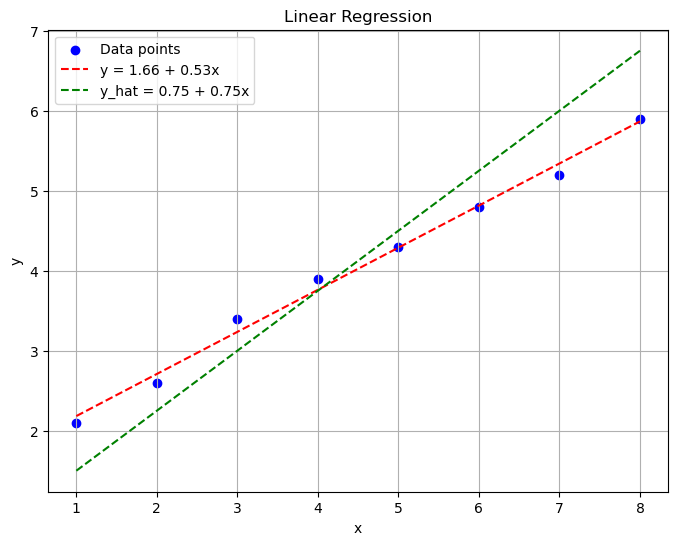

In [85]:
P = getPrecisionMatrix(precision_vector_list)
A, b = build_QUBO(X, Y, P)
z = mock_qubo_solver(A, b)
print("Best z:", z)

w = P@z
print("w:", w)
y_hat = X@w
print("Predicted y:", y_hat)
print("Actual y:", Y)
print("RSS:", np.sum((Y - y_hat)**2))
print("R^2 score:", r2_score(Y, y_hat))
# Create points for the line
x_line = np.linspace(1, 8, 100)
y_line = W[0] + W[1] * x_line

y_hat_line = w[0] + w[1] * x_line

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 1], Y, color='blue', label='Data points')
plt.plot(x_line, y_line, 'r--', label=f'y = {W[0]:.2f} + {W[1]:.2f}x')
plt.plot(x_line, y_hat_line, 'g--', label=f'y_hat = {w[0]:.2f} + {w[1]:.2f}x')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

In [86]:
P = getPrecisionMatrix(precision_vector_list)
w = getQUBO_test(X, Y, P)
print("w:", w)
y_hat = X@w
print("Predicted y:", y_hat)
print("Actual y:", Y)
print("RSS:", np.sum((Y - y_hat)**2))
print("R^2 score:", r2_score(Y, y_hat))




Best weights: [0.75 0.75]
w: [0.75 0.75]
Predicted y: [1.5  2.25 3.   3.75 4.5  5.25 6.   6.75]
Actual y: [2.1 2.6 3.4 3.9 4.3 4.8 5.2 5.9]
RSS: 2.269999999999999
R^2 score: 0.806231327358088
